In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
df = pd.read_csv('./result/air_1000_0.042_time.csv')

In [26]:
real = pd.read_csv("./dataset/pm25_ground.txt").drop(['datetime'], axis = 1)
missing = pd.read_csv("./dataset/pm25_missing.txt").drop(['datetime'], axis = 1)
Nonscale_imputataion = pd.DataFrame(df.values , columns = real.columns)
Nonscale_imputataion = (Nonscale_imputataion * missing.std()) + missing.mean()
target = torch.tensor(missing.values).T.to(device).reshape(36,len(missing))
target_real = torch.tensor(real.values).T.to(device).reshape(36,len(real))
input = torch.tensor(missing.index + 1, dtype=float).to(device)

In [22]:
pred = torch.tensor(Nonscale_imputataion.values).T.to(device).reshape(36,len(Nonscale_imputataion))

In [27]:
real_missing = torch.where(target_real.isnan(), 0.0, 1.0)
train_missing = torch.where(target.isnan(), 0.0, 1.0)

In [28]:
test_missing = real_missing - train_missing

In [29]:
rbf_masking = torch.where(target.isnan(), 0.0 , 1.0)
longterm_dict = {}
for i in range(rbf_masking.size(0)):
    long_term_missing_index = []
    a = torch.where(rbf_masking[i] == 1)[0][1:] - torch.where(rbf_masking[i] == 1)[0][:-1]
    b = torch.where(a > 100)[0]
    if len(b) > 0:
        for index in b:
            start_index = torch.where(rbf_masking[i] == 1)[0][index]
            end_index = torch.where(rbf_masking[i] == 1)[0][index + 1]
            long_term_missing_index.append([start_index, end_index])
            tensor_ = torch.arange(start_index, end_index)

        masked = torch.tensor([])
        for list_ in long_term_missing_index:
            long_index = torch.arange(list_[0], list_[1])
            masked = torch.cat([masked, long_index])
        longterm_dict[i] = masked

In [34]:
def shotterm_loss(pred, real, longterm_dict,test_missing):
    mae = 0.0
    len_ = 0.0
    for i in range(pred.size(0)):
        if i in longterm_dict.keys():
            print(i, longterm_dict[i].size())
            pred_shot = pred[i][torch.logical_not(torch.isin(torch.arange(len(pred[i])), longterm_dict[i].to(int)))][test_missing[i][torch.logical_not(torch.isin(torch.arange(len(test_missing[i])), longterm_dict[i].to(int)))] != 0]
            real_shot = real[i][torch.logical_not(torch.isin(torch.arange(len(real[i])), longterm_dict[i].to(int)))][test_missing[i][torch.logical_not(torch.isin(torch.arange(len(test_missing[i])), longterm_dict[i].to(int)))] != 0]
            mae += torch.sum(torch.abs(pred_shot - real_shot))
        else:
            # print(i, (torch.sum(test_missing[i])))
            mae += torch.sum(torch.abs(pred[i][test_missing[i] != 0] - real[i][test_missing[i] != 0]))
            len_ += torch.sum(test_missing[i])
    print(mae / len_)
    print(len_)

In [35]:
shotterm_loss(pred, target_real, longterm_dict, test_missing)

0 torch.Size([251])
6 torch.Size([693])
7 torch.Size([1001])
13 torch.Size([337])
18 torch.Size([445])
31 torch.Size([528])
33 torch.Size([429])
34 torch.Size([1051])
35 torch.Size([354])
tensor(32.3048, device='cuda:0', dtype=torch.float64)
tensor(24209., device='cuda:0')


In [37]:
mae = 0.0
for i in range(36):
    mae += torch.sum(torch.abs(pred[i][test_missing[i] != 0] - target_real[i][test_missing[i] != 0]))
mae / torch.sum(test_missing)

tensor(25.2770, device='cuda:0', dtype=torch.float64)

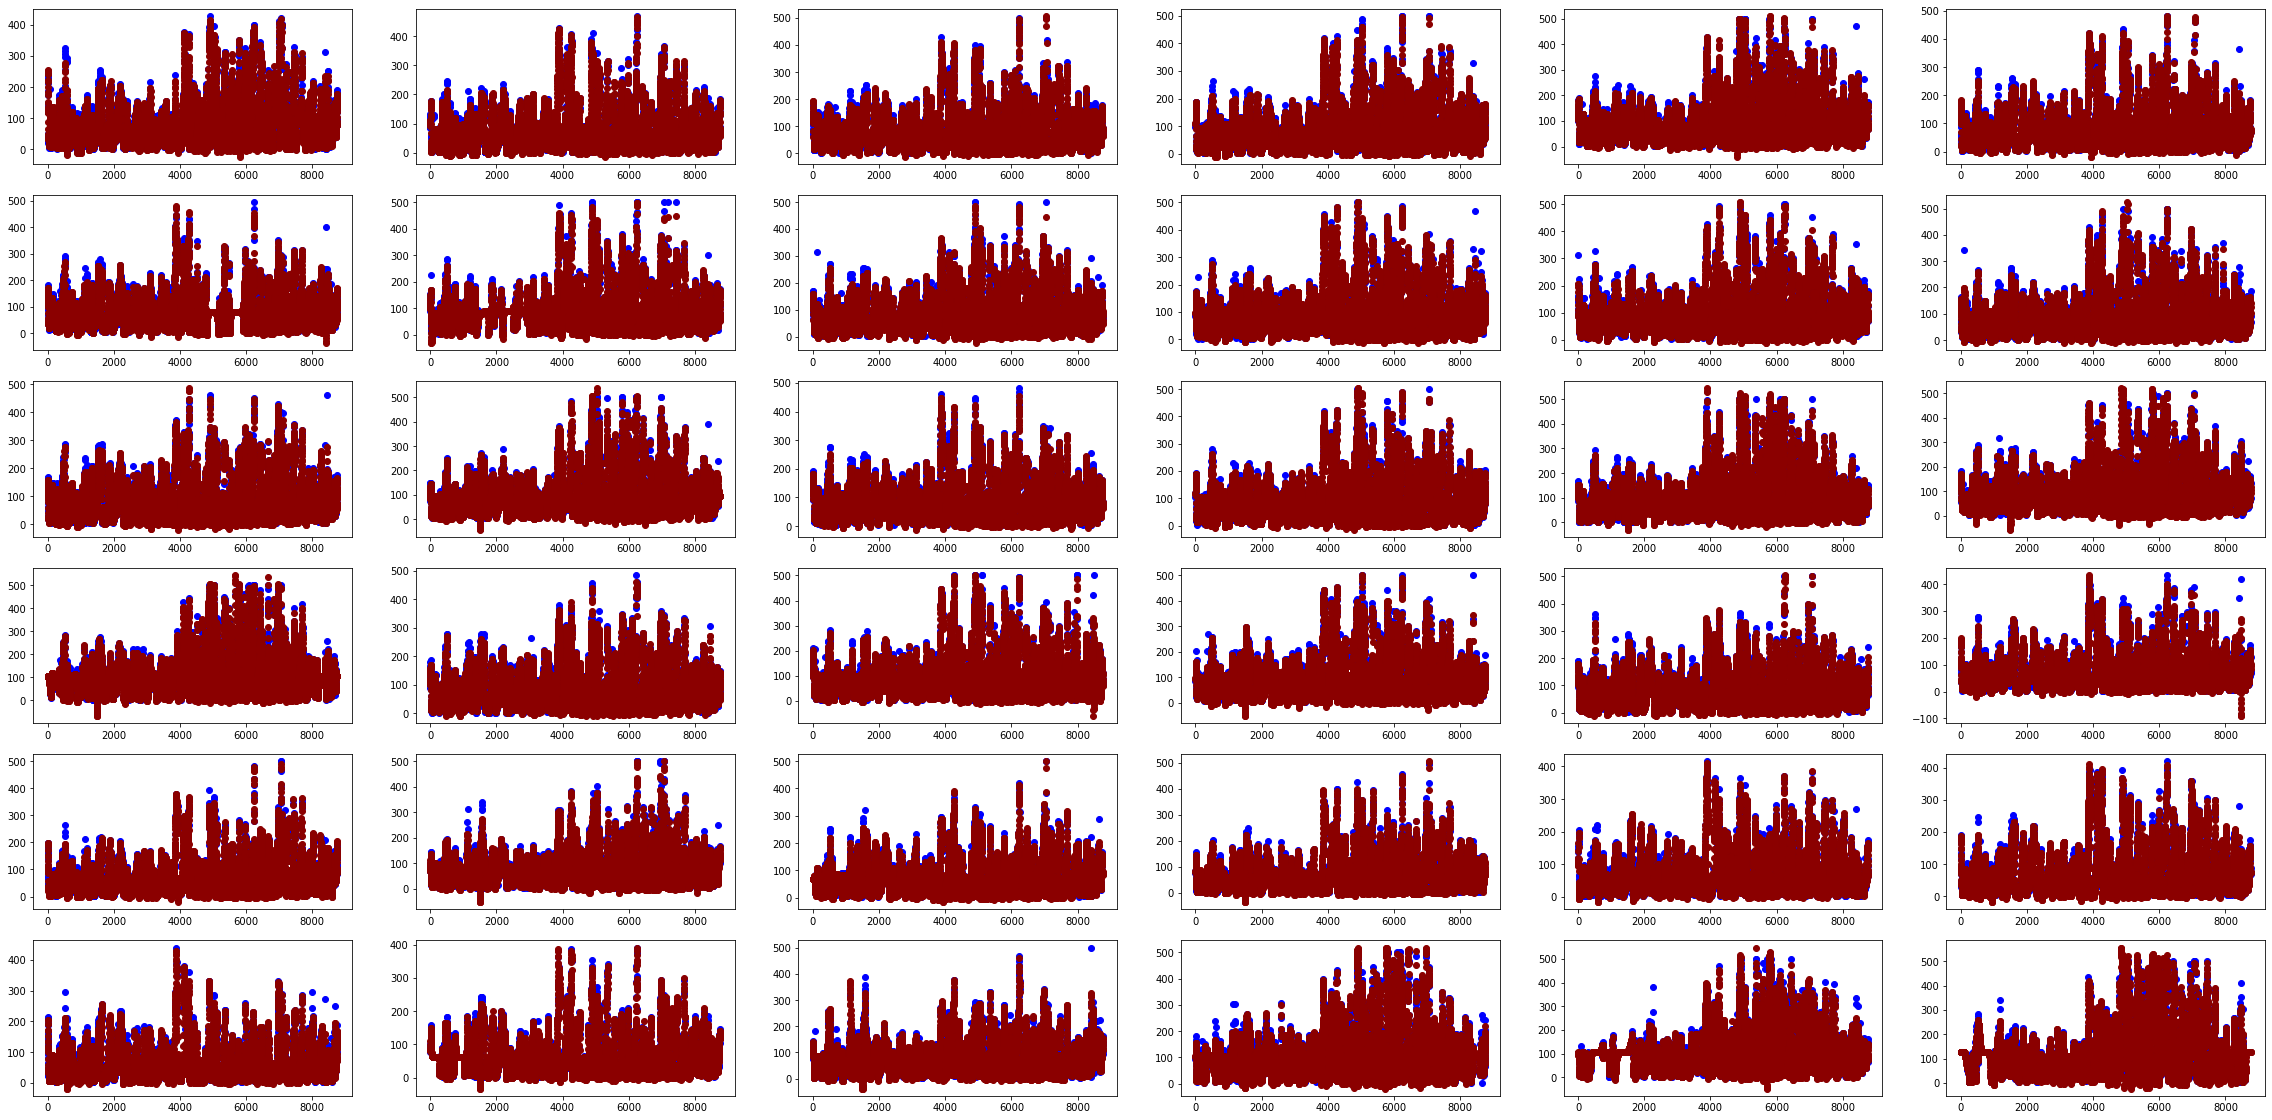

In [24]:
# 그래프 크기와 서브플롯 생성
fig, ax = plt.subplots(6, 6, figsize=(40, 20))

# 각 서브플롯에 산점도 그래프 그리기
for i in range(6):
    for j in range(6):
        idx = i *6 + j
        ax[i, j].scatter(input.cpu().detach().numpy(), target[idx].cpu().detach().numpy(), c = 'blue')
        ax[i, j].scatter(input.cpu().detach().numpy(), pred[idx].cpu().detach().numpy(), c= 'darkred')
# 그래프 표시
plt.show()